Use the NLTK toolkit for importing the Brown corpus

In [9]:
import nltk
from nltk.corpus import brown
import numpy as np
nltk.download('brown')
brown.categories()

[nltk_data] Downloading package brown to /root/nltk_data...
[nltk_data]   Unzipping corpora/brown.zip.


['adventure',
 'belles_lettres',
 'editorial',
 'fiction',
 'government',
 'hobbies',
 'humor',
 'learned',
 'lore',
 'mystery',
 'news',
 'religion',
 'reviews',
 'romance',
 'science_fiction']

Here we will use a portion of the corpus:
the “news” category. Load the tagged sentences for this portion of the corpus. Then, divide the
obtained corpus into training set and test set such that the test set is formed by the last 10% of
the sentences.

In [10]:
tagged_sents = brown.tagged_sents(categories='news')
n = len(tagged_sents)//10
print("Number of training samples is ",len(tagged_sents)-n )
print("Number of test samples is ",n )

Number of training samples is  4161
Number of test samples is  462


In [11]:
def find_words_tags(tagged_sents):
  data = []
  labels = []
  for tagged_sent in tagged_sents:
    for word,tag in tagged_sent:
      data.append(word)
      tag = tag.split('-')[0]
      tag = tag.split('+')[0]
      labels.append(tag)
  return data,labels

In [12]:
train_tagged_sents = tagged_sents[n:]
test_tagged_sents = tagged_sents[:n]
x_train,y_train = find_words_tags(train_tagged_sents)
x_test,y_test = find_words_tags(test_tagged_sents)

In [13]:
def create_tagged_words_list(train_tagged_sents):
  tagged_words = []
  for tagged_sent in train_tagged_sents:
    for word,tag in tagged_sent:
      tag = tag.split('-')[0]
      tag = tag.split('+')[0]
      tagged_words.append((word,tag))
  return tagged_words

In [14]:
def find_all_possible_tags(tagged_sents):
  tags = []
  for tagged_sent in tagged_sents:
    for word,tag in tagged_sent:
      tag = tag.split('-')[0]
      tag = tag.split('+')[0]
      tags.append((tag))
  return tags

In [15]:
from collections import Counter
words_count = Counter(x_train)
tags_count = Counter(y_train)
tagged_words= create_tagged_words_list(train_tagged_sents)
tags_words_count = Counter(tagged_words)
tags_set = set(y_train)
words_set = set(x_train)
res = list(zip(y_train, y_train[1:] + y_train[:1])) 
pairs_counter = Counter(res)
all_tags = find_all_possible_tags(tagged_sents)
all_tags_set = set(all_tags)

In [ ]:
print("Number of all possible tags : ", len(all_tags_set))
print("Number of all tags in train set : ", len(tags_set))

Number of all possible tags :  99
Number of all tags in train set :  98


# Implementation of the most likely tag baseline


Using the training set, compute for each word the tag that maximizes p(tag|word), based on the maximum likelihood estimation. 


In [ ]:
def most_freq_tag_for_word(words_set,tags_set,words_count,tags_words_count):
  dct = {}
  #most frequent tag for a word
  for word in words_set:
    max_prob = 0
    prob=0
    word_count = words_count[word]
    for tag in tags_set:
      tag_word_count = tags_words_count[word,tag]
      if(tag_word_count):
        prob = tag_word_count/word_count
        if(prob>max_prob):
          max_prob = prob
          dct[word] = tag
  return dct

In [ ]:
dct = most_freq_tag_for_word(words_set,tags_set,words_count,tags_words_count)

Using the test set, compute the error rate (i.e., 1−accuracy) for known words and for unknown words, as well as the total error rate.

In [ ]:
def compute_err_rate(x_test,y_test,dct):
  count_seen = 0
  count_unseen= 0
  seen = 0
  unseen=0
  for (word,tag) in zip(x_test,y_test):
    if(word in dct):
      seen = seen + 1
      y = dct[word]
      if(tag==y):
        count_seen = count_seen+1
    else:
      unseen = unseen + 1
      # Assume that the most likely tag of all the unknown words is “NN”. 
      y='NN'
      if(tag==y):
        count_unseen = count_unseen+1
  acc_seen = count_seen/seen
  acc_unseen = count_unseen / unseen
  print('Known Words Accuracy: %4.1f%%' % (100.0 * acc_seen))
  print('Known Words Error Rate: %4.1f%%' % (100.0 * (1-acc_seen)))
  print('Unknown Words Accuracy: %4.1f%%' % (100.0 * acc_unseen))
  print('Unknown Words Error Rate: %4.1f%%' % (100.0 * (1-acc_unseen)))
  total_acc = (count_seen + count_unseen ) / (seen + unseen)
  print('Total Accuracy: %4.1f%%' % (100.0 * total_acc))
  print('Total Error Rate: %4.1f%%' % (100.0 * (1-total_acc)))

In [ ]:
compute_err_rate(x_test,y_test,dct)

Known Words Accuracy: 93.9%
Known Words Error Rate:  6.1%
Unknown Words Accuracy: 26.8%
Unknown Words Error Rate: 73.2%
Total Accuracy: 88.1%
Total Error Rate: 11.9%


The trivial baseline finds a tag that maximize the probabality of a word given a tag. P(word|tag) = frequency(word, tag) / frequency of word. The most likely tag baseline does not generlize well on unknown words - high error rate (low accuracy). 

# Implementation of a bigram HMM tagger

Training phase: Compute the transition and emission probabilities of a bigram HMM tagger
directly on the training set using maximum likelihood estimation.

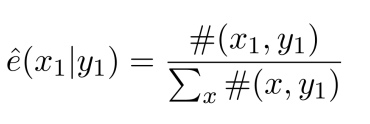

In [16]:
def emission_prob_dict(x_train,y_train,tags_words_count,tags_count):
  emission = {}
  for word,tag in zip(x_train,y_train):
    res =tags_words_count[word,tag] / tags_count[tag]
    emission[word,tag] = res
  return emission

In [25]:
emission = emission_prob_dict(x_train,y_train,tags_words_count,tags_count)

the transition probability from state i-1 to state i is given by the total number of times we observe state i-1 transitioning to state i divided by the total number of times we observe state i-1.

In [17]:
def transition_prob_dict(y_train,tags_count):
  transition = {}
  res = list(zip(y_train, y_train[1:] + y_train[:1])) 
  pairs_counter = Counter(res)
  for i in range(len(y_train)-1):
    num_of_y1 = tags_count[y_train[i]]
    num_of_y1_y2 = pairs_counter[y_train[i],y_train[i+1]]
    transition[y_train[i],y_train[i+1]] = num_of_y1_y2/num_of_y1
  return transition

In [26]:
transition = transition_prob_dict(y_train,tags_count)

Implement the Viterbi algorithm corresponding to the bigram HMM model. (Choose an
arbitrary tag for unknown words.)

In [ ]:
def viterbi(obs, states, start_p, trans_p, emit_p,tags_set,words_set):
  V = [{}]
  for st in states:
    if st in tags_set:
      if obs[0] in words_set:
        e_first_w = emit_p[st][obs[0]]
      else:
        e_first_w = 0  
      V[0][st] = {"prob": start_p[st] * e_first_w, "prev": None}
    else:
      V[0][st] = {"prob": 0, "prev": None} 
  for t in range(1, len(obs)):
    V.append({})
    for st in states:
      if st in tags_set:
            max_tr_prob = V[t - 1][states[0]]["prob"] * trans_p[states[0]][st]
            prev_st_selected = states[0]
            for prev_st in states[1:]:
              if prev_st in tags_set:
                tr_prob = V[t - 1][prev_st]["prob"] * trans_p[prev_st][st]
                if tr_prob > max_tr_prob:
                  max_tr_prob = tr_prob
                  prev_st_selected = prev_st
            if obs[t] in words_set:
              max_prob = max_tr_prob * emit_p[st][obs[t]]
            else:
              max_prob = 0
            V[t][st] = {"prob": max_prob, "prev": prev_st_selected}
      else:
        V[t][st] = {"prob": 0, "prev": 'NN'}
    if obs[t] not in words_set:
      V[t]['NN']["prob"] = 1  
  opt = []
  max_prob = 0.0
  previous = None

  for st, data in V[len(obs)-1].items():
        if data["prob"] > max_prob:
            max_prob = data["prob"]
            best_st = st
        if data["prob"] ==0:
            best_st='NN'
          
  opt.append(best_st)
  previous = best_st

  for t in range(len(obs) - 2, -1, -1):
        opt.insert(0, V[t + 1][previous]["prev"])
        previous = V[t + 1][previous]["prev"]
  return opt

Run Viterbi algorithm on the test set.

In [18]:
def calculate_transition_prob(y_train,tags_set,transition):
  A = {}
  res = list(zip(y_train, y_train[1:] + y_train[:1])) 
  pairs_counter = Counter(res)
  for y1 in tags_set:
    tags_for_tag = {}
    for y2 in tags_set:
      num_of_y1_y2 = pairs_counter[y1,y2]
      if(num_of_y1_y2):
        tags_for_tag[y2] = transition[y1,y2]
      else:
        tags_for_tag[y2]=0
    A[y1] = tags_for_tag
  return A

In [19]:
def calculate_emission_prob(x_train,y_train,tags_words_count,tags_set,words_set,emission):
  B = {}
  # check=0
  for y in tags_set:
    words_for_tag = {}
    for x in words_set:
      num_of_x_y = tags_words_count[x,y]
      if(num_of_x_y):
        # check = check + 1
        words_for_tag[x] = emission[x,y]
      else:
        words_for_tag[x] = 0
    B[y] = words_for_tag
  return B

In [20]:
def calculate_init_prob(tagged_sents,tags_set):
  init_prob = {}
  first_words = []
  num_of_starts = 0
  for sentence in tagged_sents:
    start_tag = sentence[0][1]
    start_tag = start_tag.split('-')[0]
    start_tag = start_tag.split('+')[0]
    first_words.append(start_tag)
    num_of_starts = num_of_starts + 1
  first_word_tag_counter = Counter(first_words)
  for tag in tags_set:
    num_of_tags = first_word_tag_counter[tag]
    init_prob[tag] = num_of_tags/ num_of_starts
  return init_prob

In [21]:
def run_viterbi_on_each_sen(test_tagged_sents, all_tags_set, init_prob, A, B,tags_set,words_set,pseuso,laplace):
  y_true =[]
  y_pred = []
  words =[]
  true_words = []
  for s in test_tagged_sents:
    true_words_in_sen = []
    words_in_sen = []
    tags_in_sen = []
    for w,t in s:
      if pseuso:
        if w in low_frequency_words_dct :
          true_words_in_sen.append(w)
          words_in_sen.append(low_frequency_words_dct[w])
          tags_in_sen.append(t)
        elif  w in low_frequency_unknown_dct:
          true_words_in_sen.append(w)
          words_in_sen.append(low_frequency_unknown_dct[w])
          tags_in_sen.append(t)
        else:
          true_words_in_sen.append(w)
          words_in_sen.append(w)
          tags_in_sen.append(t)
      else:
        words_in_sen.append(w)
        tags_in_sen.append(t)
    if laplace:
      opt = Laplace_viterbi(words_in_sen, list(all_tags_set), init_prob, A, B,tags_set,words_set)
    else:
      opt = viterbi(words_in_sen, list(all_tags_set), init_prob, A, B,tags_set,words_set)
    y_true.append(tags_in_sen)
    y_pred.append(opt)
    words.append(words_in_sen)
    if pseuso:
      true_words.append(true_words_in_sen)
  if pseuso:
    return y_true,y_pred,true_words
  return y_true,y_pred,words

In [ ]:
A = calculate_transition_prob(y_train,tags_set,transition)
B= calculate_emission_prob(x_train,y_train,tags_words_count,tags_set,words_set,emission)
init_prob = calculate_init_prob(train_tagged_sents,tags_set)

In [ ]:
def HMM_compute_err_rate_by_sentences(y_true,y_pred,words,words_set):
  count_seen = 0
  count_unseen= 0
  seen = 0
  unseen=0
  for i in range(len(y_true)):
    s_true = y_true[i]
    s_pred = y_pred[i]
    s_words = words[i]
    for j in range(len(s_true)):
      w_true = s_true[j]
      w_pred = s_pred[j]
      w = s_words[j]
      if w in words_set:
        seen = seen + 1
        if(w_pred==w_true):
          count_seen = count_seen+1
      else:
        unseen = unseen + 1
        if(w_pred==w_true):
          count_unseen = count_unseen+1
  if(seen>0 and unseen>0):
    acc_seen = count_seen/seen
    acc_unseen = count_unseen / unseen
    print("Number of known words is ",seen)
    print("Number of unknown words is ",unseen)
    # print(count_seen,count_unseen,count_seen + count_unseen)
    print('Known Words Accuracy: %4.1f%%' % (100.0 * acc_seen))
    print('Known Words Error Rate: %4.1f%%' % (100.0 * (1-acc_seen)))
    print('Unknown Words Accuracy: %4.1f%%' % (100.0 * acc_unseen))
    print('Unknown Words Error Rate: %4.1f%%' % (100.0 * (1-acc_unseen)))
    total_acc = (count_seen + count_unseen ) / (seen + unseen)
    print('Total Accuracy: %4.1f%%' % (100.0 * total_acc))
    print('Total Error Rate: %4.1f%%' % (100.0 * (1-total_acc)))
  else:
    print("Number of words is ",seen + unseen)
    total_acc = (count_seen + count_unseen ) / (seen + unseen)
    print('Total Accuracy: %4.1f%%' % (100.0 * total_acc))
    print('Total Error Rate: %4.1f%%' % (100.0 * (1-total_acc)))

Compute the error rates and compare to the results from the most likely tag baseline.








> Run Viterbi on each sentence



In [ ]:
y_true,y_pred,words = run_viterbi_on_each_sen(test_tagged_sents, list(all_tags_set), init_prob, A, B,tags_set,words_set,pseuso = False,laplace=False)

In [ ]:
HMM_compute_err_rate_by_sentences(y_true,y_pred,words,words_set)

Number of known words is  9844
Number of unknown words is  941
7575 204 7779
Known Words Accuracy: 77.0%
Known Words Error Rate: 23.0%
Unknown Words Accuracy: 21.7%
Unknown Words Error Rate: 78.3%
Total Accuracy: 72.1%
Total Error Rate: 27.9%




> Run Viterbi on all test set



In [ ]:
opt = viterbi(x_test, list(all_tags_set), init_prob, A, B,tags_set,words_set)

In [ ]:
dct = {}
for i in range(len(x_test)):
  dct[x_test[i]] = opt[i]

In [ ]:
def HMM_compute_err_rate(x_test,y_test,dct,words_set):
  count_seen = 0
  count_unseen= 0
  seen = 0
  unseen=0
  for i in range(len(y_test)):
    word = x_test[i]
    tag = y_test[i]
    y = dct[word]
    if(word in words_set):
      seen = seen + 1
      if(tag==y):
        count_seen = count_seen+1
    else:
      unseen = unseen + 1
      if(tag==y):
        count_unseen = count_unseen+1
  acc_seen = count_seen/seen
  acc_unseen = count_unseen / unseen
  print("Number of known words is ",seen)
  print("Number of unknown words is ",unseen)
  print('Known Words Accuracy: %4.1f%%' % (100.0 * acc_seen))
  print('Known Words Error Rate: %4.1f%%' % (100.0 * (1-acc_seen)))
  print('Unknown Words Accuracy: %4.1f%%' % (100.0 * acc_unseen))
  print('Unknown Words Error Rate: %4.1f%%' % (100.0 * (1-acc_unseen)))
  total_acc = (count_seen + count_unseen ) / (seen + unseen)
  print('Total Accuracy: %4.1f%%' % (100.0 * total_acc))
  print('Total Error Rate: %4.1f%%' % (100.0 * (1-total_acc)))


In [ ]:
HMM_compute_err_rate(x_test,y_test,dct,words_set)

Number of known words is  9844
Number of unknown words is  941
Known Words Accuracy: 74.8%
Known Words Error Rate: 25.2%
Unknown Words Accuracy: 26.8%
Unknown Words Error Rate: 73.2%
Total Accuracy: 70.6%
Total Error Rate: 29.4%


# Using Add-one smoothing

Training phase: Compute the emission probabilities of a bigram HMM tagger directly on the
training set using (Laplace) Add-one smoothing.

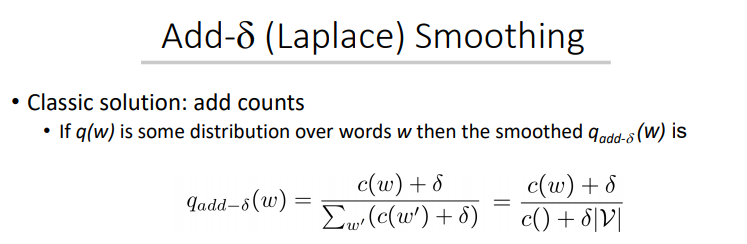

In [22]:
def Laplace_emission_prob_dict(x_train,y_train,tags_words_count,tags_count):
  emission = {}
  for word,tag in zip(x_train,y_train):
    res = (tags_words_count[word,tag]+1) / (tags_count[tag]+len(y_train))
    emission[word,tag] = res
  return emission

In [23]:
Laplace_emission = Laplace_emission_prob_dict(x_train,y_train,tags_words_count,tags_count)

Using the new probabilities, run the Viterbi algorithm on the test set. 

In [8]:
def Laplace_viterbi(obs, states, start_p, trans_p, emit_p,tags_set,words_set):
  V = [{}]
  for st in states:
    if st in tags_set:
        if obs[0] in words_set:
          e_first_w = emit_p[st][obs[0]]
        else:
          e_first_w = 1 / len(y_test)  
        V[0][st] = {"prob": start_p[st] * e_first_w, "prev": None}
    else:
      V[0][st] = {"prob": 0, "prev": None} 
  for t in range(1, len(obs)):
    V.append({})
    for st in states:
      if st in tags_set:
            max_tr_prob = V[t - 1][states[0]]["prob"] * trans_p[states[0]][st]
            prev_st_selected = states[0]
            for prev_st in states[1:]:
              if prev_st in tags_set:
                tr_prob = V[t - 1][prev_st]["prob"] * trans_p[prev_st][st]
                if tr_prob > max_tr_prob:
                  max_tr_prob = tr_prob
                  prev_st_selected = prev_st
            if obs[t] in words_set:
              max_prob = max_tr_prob * emit_p[st][obs[t]]
            else:
              max_prob = max_tr_prob * (1/len(y_test))
            V[t][st] = {"prob": max_prob, "prev": prev_st_selected}
      else:
        V[t][st] = {"prob": 0, "prev": 'NN'}
 
  opt = []
  max_prob = 0.0
  previous = None
  best_st='NN'
  for st, data in V[len(obs)-1].items():
        if data["prob"] > max_prob:
            max_prob = data["prob"]
            best_st = st
          
  opt.append(best_st)
  previous = best_st

  for t in range(len(obs) - 2, -1, -1):
        opt.insert(0, V[t + 1][previous]["prev"])
        previous = V[t + 1][previous]["prev"]
  return opt

Compute the error rates and compare to the results from bigram HMM tagger and when using Add-one smoothing.

In [27]:
A = calculate_transition_prob(y_train,tags_set,transition)
B= calculate_emission_prob(x_train,y_train,tags_words_count,tags_set,words_set,Laplace_emission)
init_prob = calculate_init_prob(train_tagged_sents,tags_set)



> Run viterbi on all test set



In [ ]:
opt = Laplace_viterbi(x_test, list(all_tags_set), init_prob, A, B,tags_set,words_set)



> Run viterbi on sentences in test set



In [ ]:
y_true,y_pred,words = run_viterbi_on_each_sen(test_tagged_sents, all_tags_set, init_prob, A, B,tags_set,words_set,False,True)
HMM_compute_err_rate_by_sentences(y_true,y_pred,words,words_set)

Number of known words is  9844
Number of unknown words is  941
Known Words Accuracy: 82.4%
Known Words Error Rate: 17.6%
Unknown Words Accuracy: 27.3%
Unknown Words Error Rate: 72.7%
Total Accuracy: 77.6%
Total Error Rate: 22.4%


Most likely tag baseline vs HMM vs HMM with Add-one

Known Words Error Rate:  6.1% 23.0% 17.6%

Unknown Words Error Rate: 73.2% 78.3% 72.7%

Total Error Rate: 11.9%  27.9% 22.4%

Therefor HMM with smoothing has lower error rate of unknown words compared to both basline and HMM without smoothing.
Also HMM with smoothing has lower error rate of known words compared to HMM without smoothing, but higher compared to baseline.


# Using pseudo-words

Design a set of pseudo-words for unknown words in the test set and low-frequency words in
the training set.

In [36]:
def create_set_unknown(x_test,x_train):
  unknown = []
  for word in x_test:
    if word not in x_train:
      unknown.append(word)
  return set(unknown)

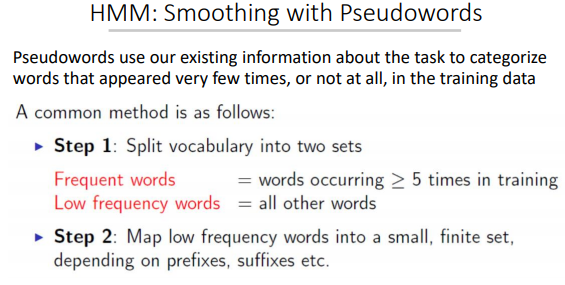

In [29]:
def create_low_frequency_set(x_train):
 low_frequency_words= []
 for word in x_train:
  if words_count[word]<5:
    low_frequency_words.append(word)
 return set(low_frequency_words)

In [30]:
import re 
def mapping(low_frequency_words):
  low_frequency_words_dct = {}
  for word in low_frequency_words:
      if re.fullmatch('[A-Za-z][0-9_-]+', word):
          low_frequency_words_dct[word] = 'digit_and_alpha'

      elif word.isdigit():
        if len(word)==2 :
          low_frequency_words_dct[word] = 'two_digit_num'
        elif len(word)==4:
          low_frequency_words_dct[word] = 'four_digit_num'
        else:
          low_frequency_words_dct[word] = 'other_num'
      elif "$" in word:
          low_frequency_words_dct[word] = 'contain_dolar'
      elif re.match('\d+/\d+/\d*', word) is not None or re.match('\d+-\d+-\d*', word) is not None:
          low_frequency_words_dct[word] = 'date'
      elif re.fullmatch('[A-Z]', word[0]):
          low_frequency_words_dct[word] = 'Init_Cap'
      elif re.fullmatch('[a-z]+', word):
          low_frequency_words_dct[word] = 'lowercase'
      else:
        low_frequency_words_dct[word] = 'other'
  return low_frequency_words_dct

In [31]:
def create_pseudo_x_test(x_test,low_frequency_words_dct,low_frequency_unknown_dct):
  pseudo_x_test = []
  for w in x_test:
    if w in low_frequency_words_dct :
      pseudo_x_test.append(low_frequency_words_dct[w])
    elif  w in low_frequency_unknown_dct:
      pseudo_x_test.append(low_frequency_unknown_dct[w])
    else:
      pseudo_x_test.append(w)
  return pseudo_x_test

In [32]:
def create_pseudo_x_train(x_train,low_frequency_words_dct):
  pseudo_x_train = []
  for w in x_train:
    if w in low_frequency_words_dct :
      pseudo_x_train.append(low_frequency_words_dct[w])
    else:
      pseudo_x_train.append(w)
  return pseudo_x_train

In [33]:
def create_pseudo_tagged_words_list(train_tagged_sents,low_frequency_words_dct):
  pseudo_tagged_words = []
  for tagged_sent in train_tagged_sents:
    for word,tag in tagged_sent:
      tag = tag.split('-')[0]
      tag = tag.split('+')[0]
      if word in low_frequency_words_dct:
        pseudo_tagged_words.append((low_frequency_words_dct[word],tag))
      else:
         pseudo_tagged_words.append((word,tag))
  return pseudo_tagged_words

In [37]:
unknown_pseudo_words  = create_set_unknown(x_test,x_train)
low_frequencyn_pseudo_words = create_low_frequency_set(x_train)
low_frequency_unknown_dct  =  mapping(unknown_pseudo_words)
low_frequency_words_dct  =  mapping(low_frequencyn_pseudo_words)
pseudo_x_test = create_pseudo_x_test(x_test,low_frequency_words_dct,low_frequency_unknown_dct)
pseudo_x_train = create_pseudo_x_train(x_train,low_frequency_words_dct)

In [38]:
pseudo_tags_words = create_pseudo_tagged_words_list(train_tagged_sents,low_frequency_words_dct)
pseudo_tags_words_count = Counter(pseudo_tags_words)
pseudo_words_set = set(pseudo_x_train)

In [39]:
pseudo_emission = emission_prob_dict(pseudo_x_train,y_train,pseudo_tags_words_count,tags_count)
B= calculate_emission_prob(pseudo_x_train,y_train,pseudo_tags_words_count,tags_set,pseudo_words_set,pseudo_emission)

In [ ]:
A = calculate_transition_prob(y_train,tags_set,transition)

Using the pseudo-words as well as maximum likelihood estimation , run the Viterbi algorithm on the test set. 

In [ ]:
y_true,y_pred,true_words = run_viterbi_on_each_sen(test_tagged_sents, list(all_tags_set), init_prob, A, B,tags_set,pseudo_words_set,True,False)

Compute the error rates and compare to the results from baseline,HMM,Add-one smoothing.



> Run Vetrbo on sentences from test set



In [ ]:
def HMM_pseudo_compute_err_rate_by_sentences(y_true,y_pred,true_words,low_frequency_unknown_dct):
  count_seen = 0
  count_unseen= 0
  seen = 0
  unseen=0
  for i in range(len(y_true)):
    s_true = y_true[i]
    s_pred = y_pred[i]
    s_words = true_words[i]
    for j in range(len(s_true)):
      w_true = s_true[j]
      w_pred = s_pred[j]
      w = s_words[j]
      if w not in low_frequency_unknown_dct:
        seen = seen + 1
        if(w_pred==w_true):
          count_seen = count_seen+1
      else:
        unseen = unseen + 1
        if(w_pred==w_true):
          count_unseen = count_unseen+1
  if(seen>0 and unseen>0):
    acc_seen = count_seen/seen
    acc_unseen = count_unseen / unseen
    print("Number of known words is ",seen)
    print("Number of unknown words is ",unseen)
    print('Known Words Accuracy: %4.1f%%' % (100.0 * acc_seen))
    print('Known Words Error Rate: %4.1f%%' % (100.0 * (1-acc_seen)))
    print('Unknown Words Accuracy: %4.1f%%' % (100.0 * acc_unseen))
    print('Unknown Words Error Rate: %4.1f%%' % (100.0 * (1-acc_unseen)))
    total_acc = (count_seen + count_unseen ) / (seen + unseen)
    print('Total Accuracy: %4.1f%%' % (100.0 * total_acc))
    print('Total Error Rate: %4.1f%%' % (100.0 * (1-total_acc)))
  else:
    print("Number of words is ",seen + unseen)
    total_acc = (count_seen + count_unseen ) / (seen + unseen)
    print('Total Accuracy: %4.1f%%' % (100.0 * total_acc))
    print('Total Error Rate: %4.1f%%' % (100.0 * (1-total_acc)))

In [ ]:
HMM_pseudo_compute_err_rate_by_sentences(y_true,y_pred,true_words,low_frequency_unknown_dct)

Number of known words is  9844
Number of unknown words is  941
Known Words Accuracy: 78.1%
Known Words Error Rate: 21.9%
Unknown Words Accuracy: 47.4%
Unknown Words Error Rate: 52.6%
Total Accuracy: 75.4%
Total Error Rate: 24.6%


**Most likely tag baseline vs HMM vs Add-one smoothing vs Pseudo Words** 

Known Words Error Rate:  6.1% 23.0% 17.6% 21.9%

Unknown Words Error Rate: 73.2% 78.3% 72.7% 52.6%

Total Error Rate: 11.9%  27.9% 22.4% 24.6%


> Can also smooth transition matrix (not used)



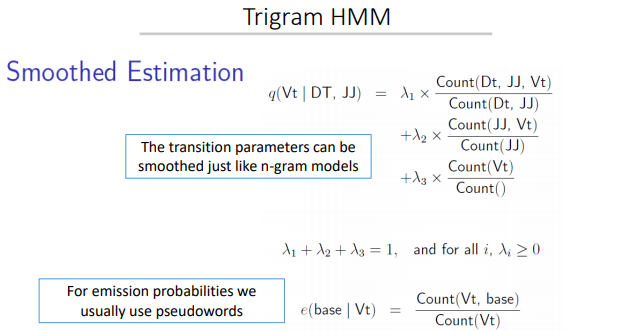

In [ ]:
def ps_words_transition_prob_dict(y_train,tags_count):
  transition = {}
  res = list(zip(y_train, y_train[1:] + y_train[:1])) 
  pairs_counter = Counter(res)
  for i in range(len(y_train)-1):
    num_of_y1 = tags_count[y_train[i]]
    num_of_y2 = tags_count[y_train[i+1]]
    num_of_y1_y2 = pairs_counter[y_train[i],y_train[i+1]]
    big = num_of_y1_y2/num_of_y1
    uni = num_of_y2/len(y_train)
    transition[y_train[i],y_train[i+1]] = (0.25 * uni) + (0.75*big) 
  return transition

# Using the pseudo-words & Add-One smoothing

Using the pseudo-words as well as Add-One smoothing (as in d)i)), run the Viterbi algorithm
on the test set.  


In [40]:
pseudo_laplace_emission = Laplace_emission_prob_dict(pseudo_x_train,y_train,pseudo_tags_words_count,tags_count)
B= calculate_emission_prob(pseudo_x_train,y_train,pseudo_tags_words_count,tags_set,pseudo_words_set,pseudo_laplace_emission)

Compute the error rates and compare to the results from baseline, HMM, Add-one smoothig, pseudo words.


> Run on sentences in test set




In [41]:
y_true,y_pred,true_words = run_viterbi_on_each_sen(test_tagged_sents, list(all_tags_set), init_prob, A, B,tags_set,pseudo_words_set,True,True)

In [ ]:
HMM_pseudo_compute_err_rate_by_sentences(y_true,y_pred,true_words,low_frequency_unknown_dct)

Number of known words is  9844
Number of unknown words is  941
Known Words Accuracy: 80.6%
Known Words Error Rate: 19.4%
Unknown Words Accuracy: 44.5%
Unknown Words Error Rate: 55.5%
Total Accuracy: 77.5%
Total Error Rate: 22.5%


**Most likely tag baseline VS HMM VS Add-one smoothing VS Pseudo Words VS Add-one smoothing & Pseudo Words** 

Known Words Error Rate:  6.1% 23.0% 17.6% 21.9% 19.4%

Unknown Words Error Rate: 73.2% 78.3% 72.7% 52.6% 55.5%

Total Error Rate: 11.9%  27.9% 22.4% 24.6% 22.5%


For the results obtained using both pseudo-words and Add-One smoothing, build a confusion matrix and investigate the most frequent errors. 

In [42]:
y = []
pred = []
words_list = []
for i in range(len(y_true)):
  s_true,s_pred,s = y_true[i],y_pred[i],true_words[i]
  for w_true,w_pred,w in zip(s_true,s_pred,s):
    y.append(w_true)
    pred.append(w_pred)
    words_list.append(w)

In [43]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y, pred)

In [54]:
np.fill_diagonal(cm, 0)
i, j = np.unravel_index(np.argmax(cm), cm.shape)
print(i,j)
print(cm[i][j])

74 70
254


# Final Results

**Most likely tag baseline vs HMM (all test) vs HMM (each sentence)**

Known Words Error Rate:  6.1% 25.2% 23.0%

Unknown Words Error Rate: 73.2% 73.2% 78.3%

Total Error Rate: 11.9% 29.4% 27.9%


**Add-one smoothing** : 

Known Words Error Rate: 17.6%

Unknown Words Error Rate: 72.7%

Total Error Rate: 22.4%

**Pseudo Words**

Known Words Error Rate: 21.9%

Unknown Words Error Rate: 52.6%

Total Error Rate: 24.6%

**Pseudo Words & Add-one smoothing**

Known Words Error Rate: 19.4%

Unknown Words Error Rate: 55.5%

Total Error Rate: 22.5%


Confusion Matrix

In [44]:
cm

array([[  0,   0,   0, ...,   0,   0,   0],
       [  4,   2,   0, ...,   0,   0,   0],
       [  6,   0, 106, ...,   0,   0,   0],
       ...,
       [  0,   0,   0, ...,  33,   0,   0],
       [  4,   0,   0, ...,   0,  22,   0],
       [  3,   0,   0, ...,   0,   0, 113]])

In [53]:
inx , cm_arr = np.nonzero(cm)
cm_arr

array([  0,   1,   0,   2,   0,   3,   3,   0,   5,  70,   5,   0,   7,
         0,   8,   8,   0,   0,  11,  70,  12,  13, 100,  14,  70,  99,
       100,   0,  15,   0,  16,  59,  70,  80,  99, 100,  16,   0,  18,
        80,  18,  18,   0,  21,   0,  22,   0,  23,  56,   0,  25,  70,
         0,  26,  27,  27,   0,  29,   0,  30,  30,   0,  32,  59,  70,
        80,  32,  32,   0,  35,  41,  56,  70,  80, 100,  35,  37,  38,
         0,  39,  40,   0,  35,  41,  59,   0,  43,   0,  44,   0,  46,
       100,  70,  47,  70,  70,   0,  51,   0,  52,  53,  52,   0,  55,
         0,  35,  56,  70,  80, 100, 103, 106, 108,  56,   0,  56,   0,
        59,  70,  75,  80, 106, 113,  59,  70,  80,   0,  59,  70,  80,
         0,  62,  70,  99,  70,  70,  59,  65,  70,   0,  66,  80,   0,
        67,  75,  80,  66,  80,   0,  59,  70,  75,  80, 106, 108, 110,
       113,   0,  59,  70,  71,  71,  80,  32,  70,  80,   0,  70,  80,
         0,  59,  70,  75,  80, 100, 106, 108, 113,  59,  70,  7

In [55]:
tags_arr = np.array(pred)
tags_arr[inx]

array(['NN', 'NN', 'NN', 'NN', 'JJ', 'JJ', 'NN', 'VBD', 'VBD', 'VBD',
       'NR', 'AT', 'AT', 'NN', 'NN', 'IN', 'NP', 'JJ', 'JJ', 'JJ', 'NN',
       'NN', 'NN', 'VBD', 'VBD', 'VBD', 'VBD', '``', '``', 'AT', 'AT',
       'AT', 'AT', 'AT', 'AT', 'AT', 'NN', "''", "''", "''", 'CS', 'DTI',
       'NN', 'NN', 'VBD', 'VBD', 'NN', 'NN', '.', 'AT', 'AT', 'AT', 'NN',
       'NN', 'RBR', 'VBD', 'IN', 'IN', 'JJ', 'JJ', 'NN', 'CS', 'CS', 'CS',
       'CS', 'CS', 'AT', 'NN', 'NN', 'NN', 'NN', 'NN', 'NN', 'NN', 'NN',
       'NN', ',', 'WDT', 'HVD', 'HVD', 'JJ', 'NN', 'NN', 'NN', 'IN', 'AT',
       'AT', 'NN', 'NN', ',', '``', '``', 'AT', 'NN', 'NN', 'CC', 'NNS',
       'NNS', 'IN', 'IN', 'AT', 'NN', 'IN', 'IN', 'NP', 'NP', 'NP', 'NP',
       'NP', 'NP', 'NP', 'NP', 'NP', "''", 'IN', 'IN', 'AT', 'AT', 'AT',
       'AT', 'AT', 'AT', 'AT', 'NN', 'NN', 'NN', 'IN', 'IN', 'IN', 'IN',
       'WDT', 'WDT', 'WDT', 'WDT', 'AT', 'NN', 'BEDZ', 'BEDZ', 'BEDZ',
       'VBN', 'VBN', 'VBN', '.', '.', '.', 'AT', 'N

The most frequent error was predicting the tag is a noun when actually it's a past participle (VBN).

In [ ]:
y[i],pred[j]

('VBN', 'NN')